In [1]:
import warnings
warnings.filterwarnings("ignore")

import plot
import models
from feature_ecoding.clip_surface import Fault_feature
import torch
import pandas as pd
import os
import importlib

In [2]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    num_GPU = torch.cuda.device_count()
    print(f"GPU amount: {num_GPU}")
else:
    num_GPU = 0

print(f"device: {device}")
root_path = os.path.abspath('.')

GPU amount: 1
device: cuda


1. load observational data

In [3]:
surface_points = pd.read_csv(os.path.join(root_path, 'data', 'case2', 'original_data', 'filtered_surface_points.csv'))
orientation_points = pd.read_csv(os.path.join(root_path, 'data', 'case2', 'original_data', 'filtered_orientations.csv'))
extent = [451000,456000, 6782000, 6784000, -6927, -4953]

In [4]:
#plot.observation(surface_points, orientation_points, extent, notebook=True)

2. modeling fault surfaces

In [5]:
fault_mesh = models.fault_ConcatMLP(surface_points,     # original data read from csv file
                            orientation_points,         # original data read from csv file
                            extent,                     # domain boundary
                            resolution=[60, 30, 30],    # resolution of the fault mesh, lower resolution to reduce the computation time in feature encoding,
                            in_dim=3,                   # input dimension of neural network
                            hidden_dim=256,             # hidden layer's dimension of neural network
                            out_dim=1,                  # output dimension of neural network, the only output is a scalar value
                            n_hidden_layers=2,          # number of hidden layers
                            activation='Softplus',      # activation function, default is 'Softplus'
                            beta_list=[25, 70],         # `beta` values for Softplus activation function, the length related to the number of faults
                            concat = True,              # whether to concat the input features to hidden layers
                            epochs=3000,                # number of forward and backward propagation process 
                            lr=0.001,                   # learning rate
                            above_below=True)           # whether to use `above_below` loss function, default is False

Finish modeling fault3 | Loss_i: 0.016700157895684242, Loss_o: 0.05635257437825203, Loss_ab:0.0
Finish modeling fault4 | Loss_i: 0.012287864461541176, Loss_o: 0.058752622455358505, Loss_ab:0.0
------Finish-------


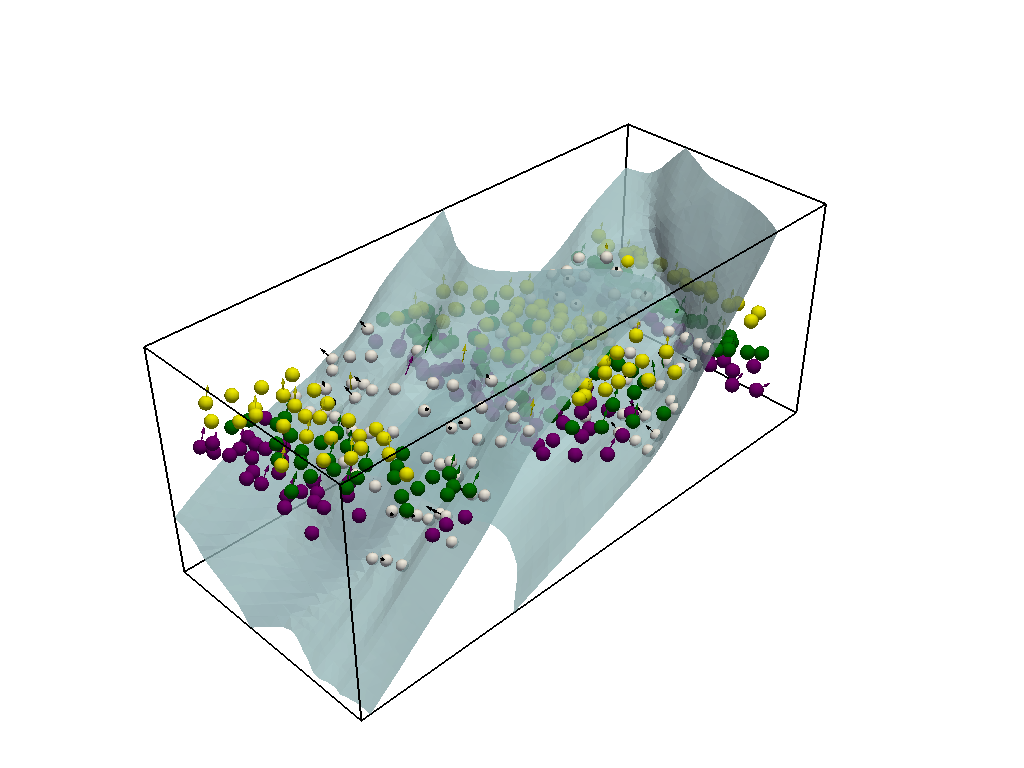

In [6]:
plot.fault_mesh(fault_mesh, surface_points, orientation_points, extent, notebook=True)

In [7]:
#plot.observation_fault_mesh(surface_points, orientation_points, extent, fault_mesh, notebook=True)

3. fault feature encoding

In [8]:
domain_mesh_features, label_interf_all, orie_points_all = Fault_feature.encoding(extents=extent,    # domain boundary
                                                            resolution=[100, 100, 100],             # resolution of the domain mesh
                                                            mesh_list=fault_mesh,                   # fault mesh list
                                                            surface_points=surface_points,          # original data read from csv file
                                                            orientation_points=orientation_points,  # original data read from csv file
                                                            movement=['down','down'],               # 'up' or 'down', relative movement in fault right side
                                                            fault_direct=['right','right'],         # fault surface direction, insures correct feature encoding
                                                            decimate=0.0)                           # reserve all the points in fault mesh

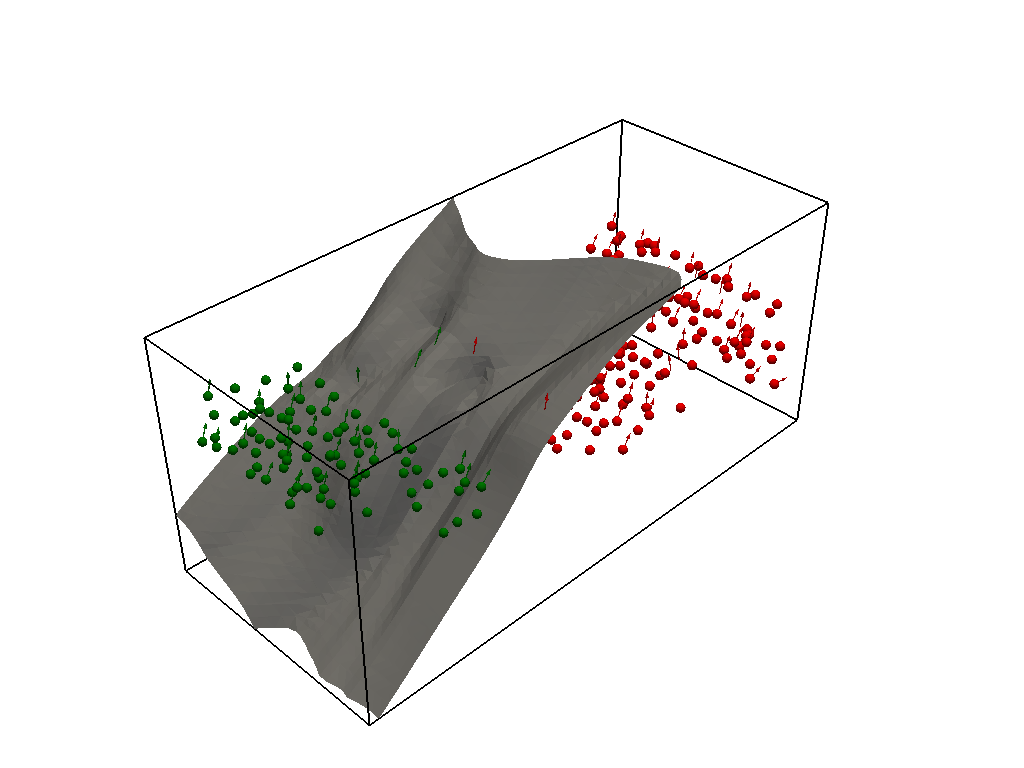

In [9]:
plot.feature_encoding(mesh_list=fault_mesh,                      # fault mesh list after editing
                      number=0,                                  # 0 is the first mesh, 1 is the second mesh
                      extent=extent,                             # domain boundary
                      type='obs_point',                          # 'mesh_point' or 'obs_point', visualization type
                      side='up',                                 # 'up' or 'down', 'up' is the side which assigned value 1 in the feature encoding
                      domain_mesh_features=domain_mesh_features, # meshgrid points of interpreated domain
                      label_interf_all=label_interf_all,         # strtigraphic points with labels
                      orie_points_all=orie_points_all,           # orientation points 
                      notebook=True)

4. modeling the discontinuious stratigraphic

In [10]:
stratigraphic_mesh, scalar_field_strat = models.stratigraphic_ConcatMLP(interface_data=label_interf_all,  # stratigraphic points with labels
                                            orientation_data=orie_points_all,     # orientation points
                                            meshgrid_data=domain_mesh_features,   # meshgrid points of interpreated domain
                                            extent=extent,                        # domain boundary
                                            resolution=[100, 100, 100],           # resolution of the domain mesh
                                            in_dim=5,                             # input dimension of neural network
                                            hidden_dim=512,                       # hidden layer's dimension of neural network
                                            out_dim=1,                            # output dimension of neural network, the only output is a scalar value
                                            n_hidden_layers=2,                    # number of hidden layers
                                            activation='Softplus',                # activation function, default is 'Softplus'
                                            beta=210,                             # `beta` value for Softplus activation function
                                            concat=True,                          # whether to concat the input features to hidden layers
                                            epochs=1000,                          # number of forward and backward propagation process
                                            lr=0.001,                             # learning rate
                                            alpha=1)                            # the efficiency of orientation loss, default is 0.1

Training losses | Loss_i: 0.482204794883728, Loss_o: 0.5115153789520264
each epoch training time :  0.0036513490676879884 seconds
Inference time: 8.988263607025146 seconds
------Finish-------


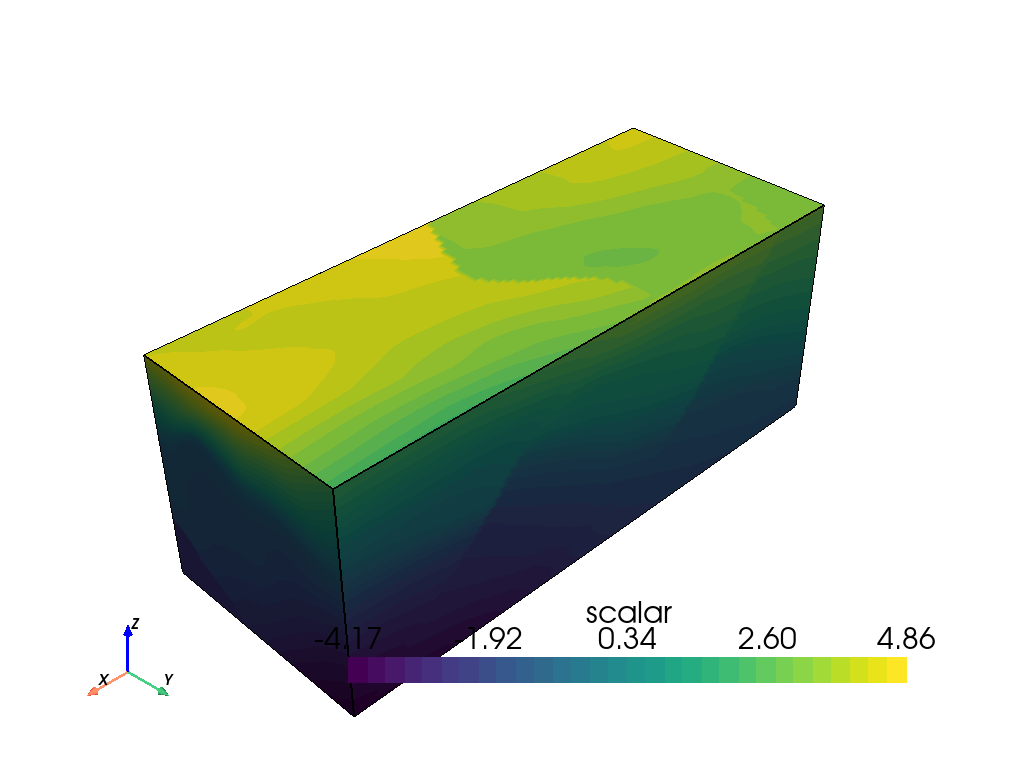

In [11]:
plot.scalar_field(scalar_field_strat, fault_mesh, notebook=True)

5. modeling the unconformity layer

In [12]:
unconformity_mesh, scalar_field_unconf = models.unconformity_ConcatMLP(surface_points, 
                                            orientation_points, 
                                            extent,
                                            resolution=[100, 100, 100], 
                                            in_dim=3,
                                            hidden_dim=256, 
                                            out_dim=1,
                                            n_hidden_layers=2,
                                            activation='Softplus',  # Softplus, ReLU , LeakyReLU, Tanh, Sigmoid, and ELU can be selected
                                            beta_list=[100],     
                                            concat = False,
                                            epochs=2000,
                                            lr=0.001,)

Finish modeling BCU | Loss_i: 0.004268969874829054, Loss_o: 0.010167177766561508
------Finish-------


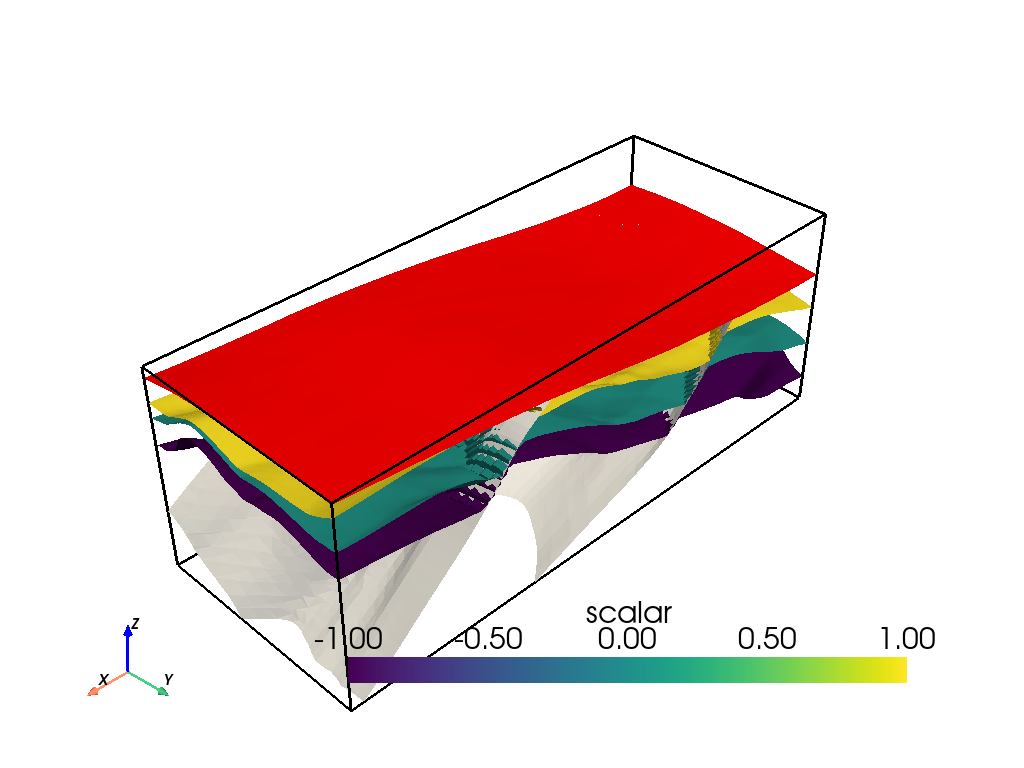

In [13]:
plot.final_structure(fautl_mesh_list = fault_mesh,
                        stratigraphic_mesh = stratigraphic_mesh,
                        unconformity_mesh_list = unconformity_mesh,
                        surface_points = surface_points,
                        orientation_points = orientation_points,
                        extent=extent,
                        unconformity=True,
                        notebook=True)

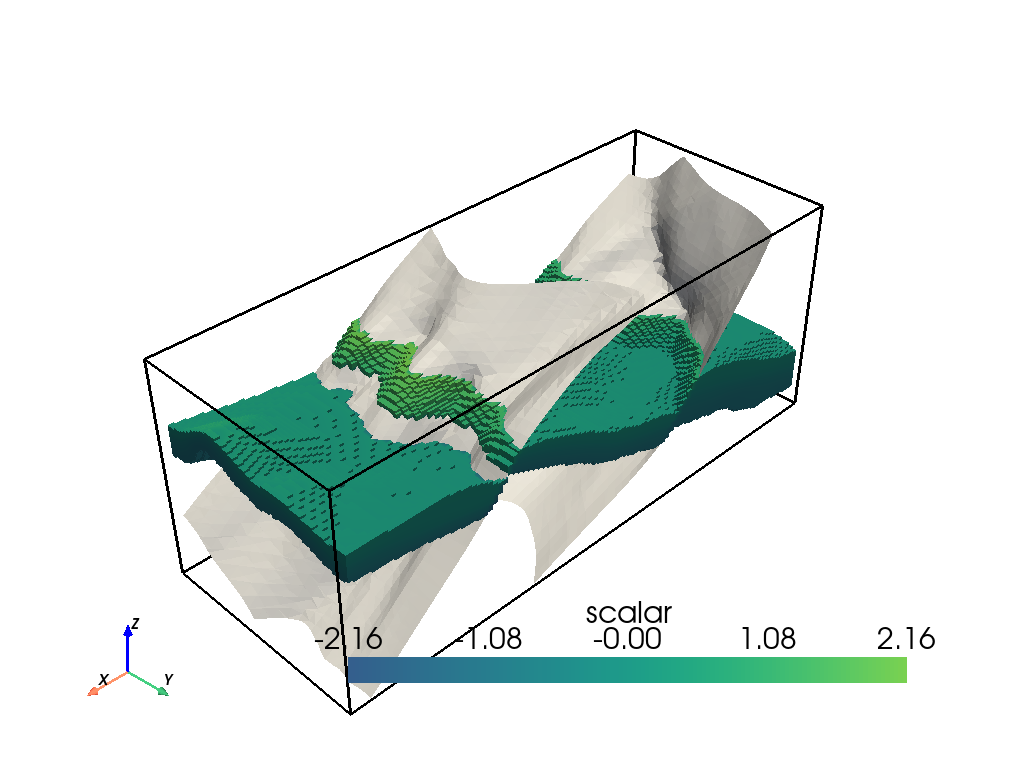

In [14]:
plot.layer(scalar_field_strat, fault_mesh, extent, notebook=True)